## Importing Libraries

In [ ]:
# # Install the requirements
# ! pip install -r requirements.txt

In [1]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    print(f"CUDA is available! Number of GPUs: {torch.cuda.device_count()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available.")

CUDA is available! Number of GPUs: 4
GPU Name: Tesla T4


In [2]:
import torch
import time
import numpy as np
from qdrant_client import QdrantClient
from qdrant_client.http import models
from tqdm import tqdm
from datasets import load_dataset

### Load the model

In [15]:
from colpali_engine.models import ColQwen2, ColQwen2colpali_colpali_processor

model_name = "vidore/colqwen2-v0.1"

colpali_model = ColQwen2.from_pretrained(
                                            model_name,
                                            torch_dtype=torch.bfloat16,
                                            device_map="cuda:0",
                                            cache_dir="./hf_cache"
                                        )

colpali_colpali_colpali_processor = ColQwen2colpali_colpali_colpali_colpali_processor.from_pretrained(model_name)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [16]:
!wget https://reseauactionclimat.org/wp-content/uploads/2018/04/powerpoint-final-kit.pdf -O test.pdf


--2025-01-10 19:18:39--  https://reseauactionclimat.org/wp-content/uploads/2018/04/powerpoint-final-kit.pdf
Resolving reseauactionclimat.org (reseauactionclimat.org)... 46.105.57.169
Connecting to reseauactionclimat.org (reseauactionclimat.org)|46.105.57.169|:443... 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


connected.
HTTP request sent, awaiting response... 200 OK
Length: 14841042 (14M) [application/pdf]
Saving to: ‘test.pdf’

test.pdf            100%[===================>]  14.15M  16.0MB/s    in 0.9s    

2025-01-10 19:18:40 (16.0 MB/s) - ‘test.pdf’ saved [14841042/14841042]



In [17]:
# convert all PDF pages to images
from pdf2image import convert_from_path
import base64
from io import BytesIO


images = convert_from_path('./test.pdf')

base64_images = []
for i in range(len(images)):
    buffered = BytesIO()
    images[i].save(buffered, format="JPEG")
    base64_images.append(base64.b64encode(buffered.getvalue()).decode('utf-8'))

In [18]:
from torch.utils.data import DataLoader

dataloader = DataLoader(
    dataset=images,
    batch_size=2,
    shuffle=False,
    collate_fn=lambda x: colpali_colpali_colpali_processor.process_images(x),
)

ds  = []
for batch_doc in tqdm(dataloader):
    with torch.no_grad():
        batch_doc = {k: v.to(colpali_model.device) for k, v in batch_doc.items()}
        embeddings_doc = colpali_model(**batch_doc)
    ds.extend(list(torch.unbind(embeddings_doc.to("cpu"))))

100%|██████████| 29/29 [04:12<00:00,  8.72s/it]


## Inference

In [28]:

def get_results(query: str):
    batch_queries = colpali_colpali_colpali_processor.process_queries([query]).to(colpali_model.device)

    # Forward pass
    with torch.no_grad():
        query_embeddings = colpali_model(**batch_queries)

    scores = colpali_colpali_colpali_processor.score_multi_vector(query_embeddings, ds)
    # get top-5 scores
    return scores[0].topk(5).indices.tolist()

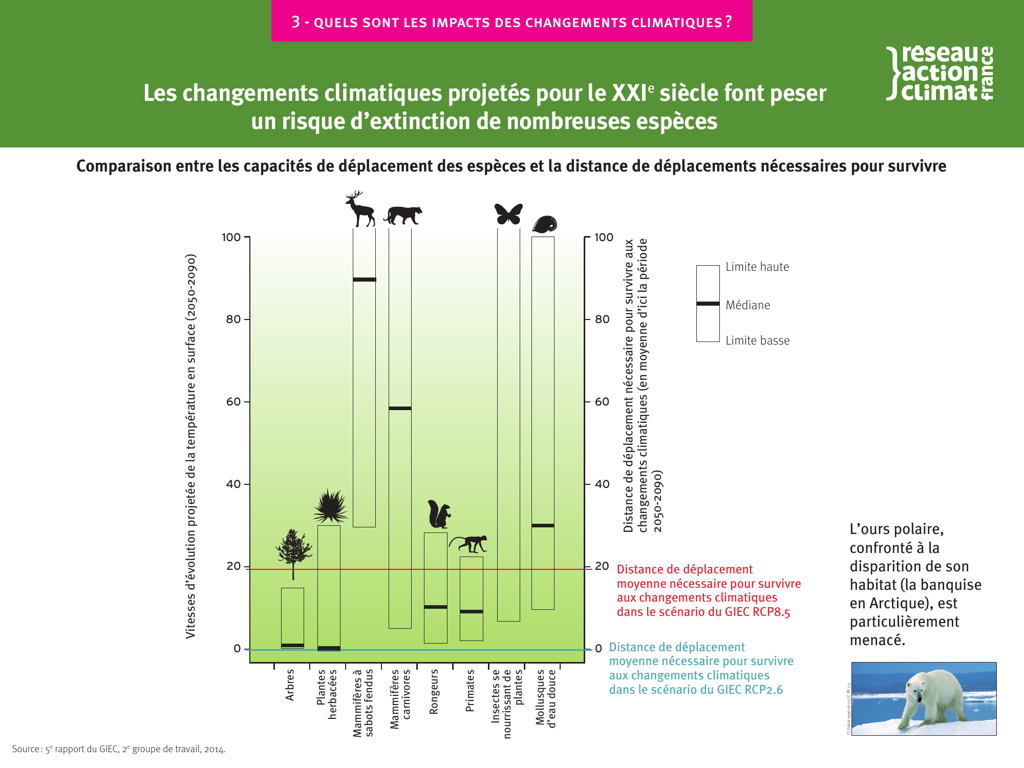

In [29]:
# display and resize keepin aspect ratio
idx = get_results("What animals are in danger with climate change ?")[0]
im = images[idx]

def display_resize(im):
    shrink_factor = (im.size[0]/1024)
    display(im.resize((int(im.size[0]/shrink_factor), int(im.size[1]/shrink_factor))))

display_resize(im)

## Interpretability

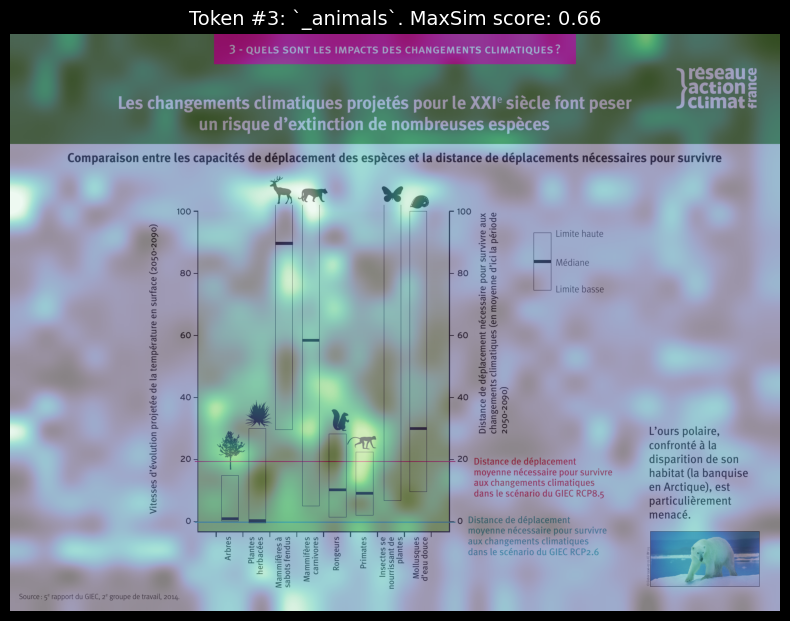

In [35]:
from colpali_engine.interpretability import (
    get_similarity_maps_from_embeddings,
    plot_all_similarity_maps,
    plot_similarity_map,
)


# Get the number of image patches
n_patches = colpali_processor.get_n_patches(
    image_size=im.size,
    patch_size=colpali_model.patch_size,
    spatial_merge_size=colpali_model.spatial_merge_size,
)


# Get the tensor mask to filter out the embeddings that are not related to the image
image_mask = colpali_processor.get_image_mask(colpali_processor.process_images([im]))

batch_queries = colpali_processor.process_queries(["What animals are in danger with climate change ?"]).to(colpali_model.device)
# Generate the similarity maps
batched_similarity_maps = get_similarity_maps_from_embeddings(
    image_embeddings=ds[idx].unsqueeze(0).to("cuda"),
    query_embeddings=colpali_model(**batch_queries),
    n_patches=n_patches,
    image_mask=image_mask,
)

query_content = colpali_processor.decode(batch_queries.input_ids[0]).replace(colpali_processor.tokenizer.pad_token, "")
query_content = query_content.replace(colpali_processor.query_augmentation_token, "").strip()
query_tokens = colpali_processor.tokenizer.tokenize(query_content)

# Get the similarity map for our (only) input image
similarity_maps = batched_similarity_maps[0]  # (query_length, n_patches_x, n_patches_y)


token_idx = 3 # for the third token

fig, ax = plot_similarity_map(
    image=im,
    similarity_map=similarity_maps[token_idx],
    figsize=(8, 8),
    show_colorbar=False,
)

max_sim_score = similarity_maps[token_idx, :, :].max().item()
ax.set_title(f"Token #{token_idx}: `{query_tokens[token_idx].replace('Ġ', '_')}`. MaxSim score: {max_sim_score:.2f}", fontsize=14)

del query_content, query_tokens, batch_queries, batched_similarity_maps, similarity_maps, image_mask, n_patches, im
     